In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 460kB 57.4MB/s 
     |████████████████████████████████| 3.0MB 35.5MB/s 
     |████████████████████████████████| 2.9MB 48.0MB/s 
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [2]:
# Unzip Data
import shutil
shutil.unpack_archive("/content/drive/MyDrive/Computer_Vision_Project/Object_Localization/Data/images.tar.gz", "/content/Data")
shutil.unpack_archive("/content/drive/MyDrive/Computer_Vision_Project/Object_Localization/Data/annotations.tar.gz", "/content/Data")

In [3]:
# Import Libraries
import matplotlib.pyplot as plt
DATASET_PATH = "/content/Data/"
import numpy as np
import pandas as pd
import cv2
import os

BATCH_SIZE = 32
IMAGE_SIZE = 128
EPOCHS = 50

In [4]:
# Converting Annotations data from XML files to csv Files
import xml.etree.ElementTree as ET
from glob import glob
from sklearn.model_selection import train_test_split
import os

images_path = os.path.join(DATASET_PATH , 'images')
annotations_path = os.path.join(DATASET_PATH ,'annotations','xmls')

all_images = glob(images_path + "/*.jpg")
print("Total Images :",len(all_images))

annotations = {'filename':[],'width':[],'height':[],'x_1':[],'x_2':[],'y_1':[],'y_2':[]}
for file in os.listdir(annotations_path):
    element_root = ET.parse(os.path.join(annotations_path,file)).getroot()
    element_object = element_root.find('object')
    annotations['filename'].append(element_root.find('filename').text)
    annotations['width'].append(element_root.find('size').find('width').text)
    annotations['height'].append(element_root.find('size').find('height').text)
    annotations['x_1'].append(int(element_object.find('bndbox').find('xmin').text))
    annotations['x_2'].append(int(element_object.find('bndbox').find('xmax').text))
    annotations['y_1'].append(int(element_object.find('bndbox').find('ymin').text))
    annotations['y_2'].append(int(element_object.find('bndbox').find('ymax').text))

annotations_df = pd.DataFrame()
for key, values in annotations.items():
    annotations_df[key] = values
annotations_df['class'] = annotations_df['filename'].apply(lambda x : str(x).split('_')[0])
annotations_df['filename'] = images_path +"/" + annotations_df['filename']

train_df , validation_df = train_test_split(annotations_df , test_size=0.20, random_state=101 , stratify=annotations_df['class'])

train_df.to_csv(DATASET_PATH + 'train_df.csv', index=False)
validation_df.to_csv(DATASET_PATH + 'validation_df.csv', index=False)

Total Images : 7390


In [5]:

from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.mobilenet import preprocess_input
import csv
import math
import cv2

class DataSequence(Sequence):
    def __init__(self, csv_file):
        self.image_path = []
        with open(csv_file , 'r') as file:
            self.coords =  np.zeros(shape = (sum(1 for line in file)-1,4))
            file.seek(0)
            reader = csv.reader(file, delimiter = ',')
            next(reader)
            for index , row in enumerate(reader):
                for i, r in enumerate(row[1:7]):
                    row[i+1] = int(r)
                filename, image_width, image_height,x_1, x_2, y_1, y_2, _ = row
                self.image_path.append(filename)
                self.coords[index,0] = (x_1 /image_width * IMAGE_SIZE)
                self.coords[index,1] = (y_1/image_height *IMAGE_SIZE)
                self.coords[index,2] = (x_2 -x_1) /image_width * IMAGE_SIZE
                self.coords[index,3] = (y_2 - y_1)/image_height *IMAGE_SIZE

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, index):
        batch_path = self.image_path[index *BATCH_SIZE :(index + 1) *BATCH_SIZE]
        batch_cords = self.coords[index *BATCH_SIZE : (index+1) *BATCH_SIZE]
        batch_images = np.zeros(shape=(len(batch_path) , IMAGE_SIZE, IMAGE_SIZE , 3), dtype=np.float32)
        for index , image_path in enumerate(batch_path):
            image = cv2.imread(image_path)
            image = cv2.resize(image, dsize=(IMAGE_SIZE,IMAGE_SIZE))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            batch_images[index] = preprocess_input(np.array(image, np.float32))
        return batch_images , batch_cords


train_generator = DataSequence(DATASET_PATH + "train_df.csv")

# Total_Training_Images = 2949


In [6]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.backend import epsilon

class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs=None):
        intersections = 0
        unions = 0
        mse = 0
        for i in np.arange(len(self.generator)):
            batch_images , gt = self.generator[i]
            predicted = self.model.predict_on_batch(batch_images)
            mse += np.linalg.norm(gt - predicted, ord='fro') / predicted.shape[0]
            inter_top_left = [np.maximum(gt[:,0],predicted[:,0])  , np.maximum(gt[:,1],predicted[:,1])]
            inter_bottom_right = [np.minimum((gt[:,0]+gt[:,2]),predicted[:,0]+predicted[:,2])  , np.minimum((gt[:,1]+gt[:,3]),predicted[:,1]+predicted[:,3])]
            inter_width = inter_bottom_right[0] - inter_top_left[0]
            inter_height = inter_bottom_right[1] - inter_top_left[1]

            area_gt = gt[:,2] * gt[:,3]
            area_pred = predicted[:,2] * predicted[:,3]

            intersection = inter_width * inter_height
            union = area_gt + area_pred - intersection

            # Compute Intersection Over Union Over Multiple Boxes
            batch_iou = 0
            for index , _ in enumerate(union):
                if union[index] > 0 and intersection[index]>0 and union[index]>=intersection[index]:
                    intersections += intersection[index]
                    unions += union[index]
        iou = np.round((intersections/unions + epsilon()),4)
        logs['val_iou'] = iou
        logs['val_mse'] = mse

validation_datagen = Validation(DataSequence(DATASET_PATH + "validation_df.csv"))

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D , Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , EarlyStopping
import pickle as pkl
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

pretrained_model = MobileNet(include_top =False, weights ='imagenet', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))
for layer in pretrained_model.layers:
    layer.trainable = True
last_output_layer = pretrained_model.layers[-1].output
x = Conv2D(filters=4, kernel_size=4, name='coordinates')(last_output_layer)
x = Reshape((4,))(x)

model = Model(inputs =pretrained_model.input, outputs = x)
model.summary()

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001),loss=['mean_squared_error'], metrics=[])

model_checkpoint = ModelCheckpoint(filepath=DATASET_PATH + "model_{val_iou:.2f}.h5", verbose=1,monitor='val_iou',mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_iou',factor=0.1, patience=10,min_lr=0, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor="val_iou",patience=10,mode='max', verbose =1)

history = model.fit_generator(generator=train_generator,callbacks=[validation_datagen,reduce_lr,model_checkpoint], epochs=EPOCHS, shuffle=True)
model.save(DATASET_PATH + "Final_Model_50_Epochs.h5")

with open(DATASET_PATH + "50_Epochs.pkl", 'wb') as file:
    pkl.dump(history.history, file)


17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
______________________________________________________________

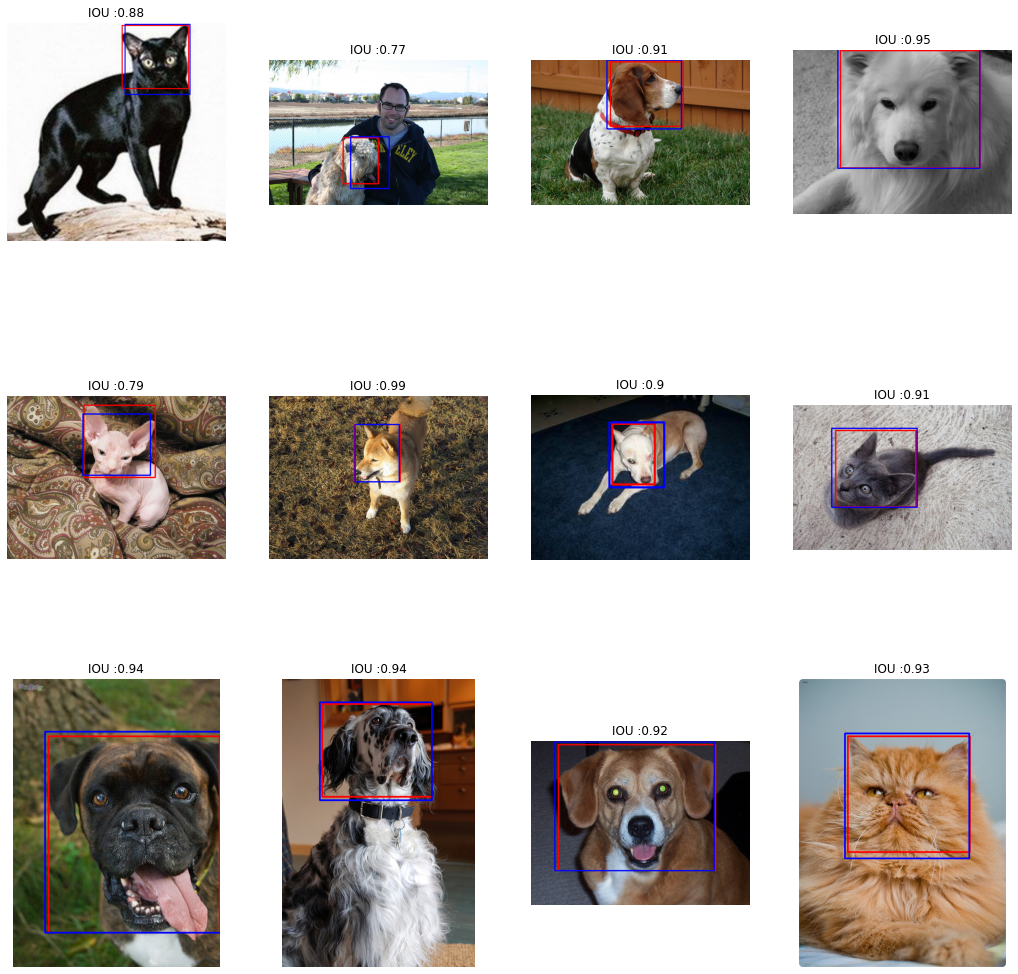

In [12]:
# Test the model on some random images
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet import preprocess_input

model = load_model('/content/drive/MyDrive/Computer_Vision_Project/Object_Localization/model_0.80.h5')
validation_df = pd.read_csv(DATASET_PATH + "validation_df.csv")
random_nos = [148, 423, 447, 109,  24, 305, 237,  97, 376, 154, 412, 484]
def calculate_iou(gt, pred):
    inter_top_left = [np.maximum(gt[0],pred[0]) , np.maximum(gt[1], pred[1])]
    inter_bottom_right = [np.minimum((gt[0]+gt[2]),pred[0]+pred[2]) , np.minimum((gt[1]+gt[3]),[pred[1]+pred[3]])]
    inter_width = inter_bottom_right[0] - inter_top_left[0]
    inter_height = inter_bottom_right[1] - inter_top_left[1]
    gt_area = gt[2] * gt[3]
    pred_area = pred[2] *pred[3]

    intersection = inter_height * inter_width
    union = gt_area + pred_area - intersection
    iou = np.round((intersection/union),2)
    return iou[0]

def predict_on_model(image):
    unscaled_image_height, unscaled_image_width , _ = image.shape
    image = cv2.resize(image,(IMAGE_SIZE,IMAGE_SIZE))
    image = preprocess_input(np.array(image, dtype=np.float16))
    image = np.expand_dims(image,axis=0)
    predicted_coords = model.predict(image)
    pred_x_1 = int(predicted_coords[0][0] /IMAGE_SIZE * unscaled_image_width)
    pred_y_1 = int(predicted_coords[0][1] /IMAGE_SIZE * unscaled_image_height)
    pred_x_2 = int((predicted_coords[0][0] + predicted_coords[0][2]) / IMAGE_SIZE * unscaled_image_width)
    pred_y_2 = int((predicted_coords[0][1] + predicted_coords[0][3]) /IMAGE_SIZE * unscaled_image_height)
    return pred_x_1,pred_y_1, pred_x_2, pred_y_2

plt.figure(figsize=(18,18))
for i in np.arange(len(random_nos)):
    plt.subplot(3,4,i+1)
    data = validation_df.iloc[random_nos[i]]
    filename, width, height, x_1, x_2, y_1, y_2,_ = data
    image = plt.imread(filename)
    pred_x_1,pred_y_1, pred_x_2, pred_y_2 = predict_on_model(image)
    cv2.rectangle(image,(x_1,y_1),(x_2,y_2),(255,0,0),2)
    cv2.rectangle(image, (pred_x_1, pred_y_1), (pred_x_2, pred_y_2), (0, 0,255), 2)
    iou = calculate_iou((x_1,y_1,x_2,y_2),(pred_x_1,pred_y_1, pred_x_2, pred_y_2))
    plt.title("IOU :{}".format(iou))
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Red Actual
# Blue Predicted

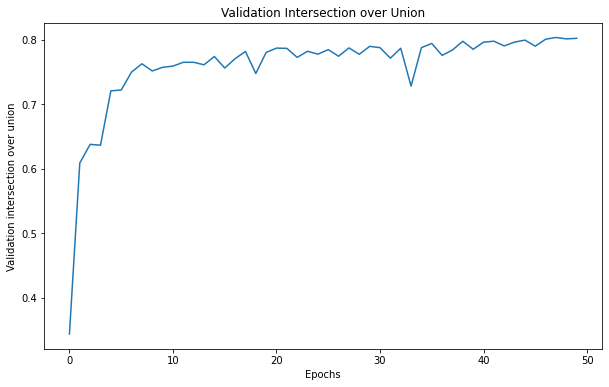

In [8]:
import pickle as pkl
with open("/content/drive/MyDrive/Computer_Vision_Project/Object_Localization/50_Epochs.pkl", 'rb') as file:
    history = pkl.load(file)
plt.figure(figsize=(10,6))
plt.plot(history['val_iou'])
plt.xlabel("Epochs")
plt.ylabel("Validation intersection over union")
plt.title("Validation Intersection over Union")
plt.show()